### **Use this Notebook on Google Colab Free GPU**
Go to Google Drive, upload this notebook and dataset folders. Rigth click notebook, choose **Open with -> Google Colab**
<br>
To activate GPU in Colab, go to **Runtime -> Change Runtime Type**. Under **Hardware accelerator** choose **GPU**

### Connect to Google Drive to access Dataset

In [ ]:
# use this link to get the data from gDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/X-Ray_Image_DataSets.zip"

Archive:  /content/gdrive/MyDrive/X-Ray_Image_DataSets.zip
   creating: X-Ray_Image_DataSet/
   creating: X-Ray_Image_DataSet/COVID/
  inflating: X-Ray_Image_DataSet/COVID/COVID-2.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-26.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-4.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-5.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-6.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-7.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-8.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-9.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-10.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-11.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-12.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-13.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-14.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-15.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-16.png  
  inflating: X-Ray_Image_DataSet/COVID/COVID-17.png  
  inflatin

### Import all dependencies

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 100
batch_size = 32

#define paths
covid_path = '/content/X-Ray_Image_DataSet/COVID'
noncovid_path = '/content/X-Ray_Image_DataSet/Normal'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [ ]:
# !rm -rf '/content/data/ct'

### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

### Visualize First 40 Images from Data set

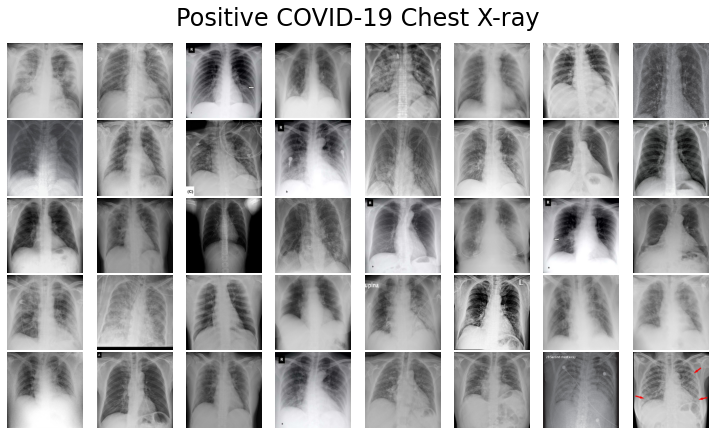

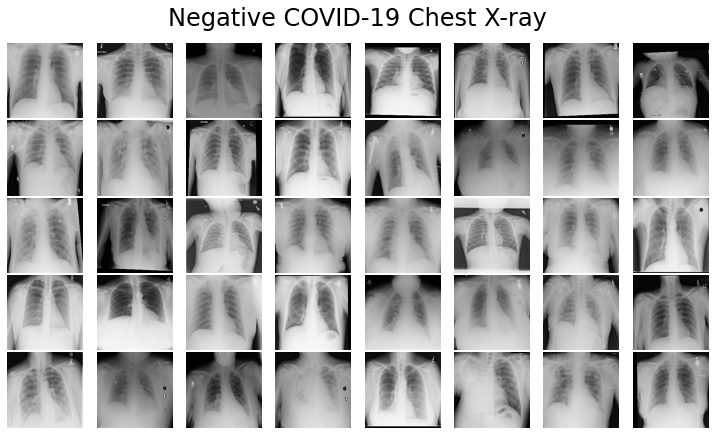

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

### **Building and Visualizing model**

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Activation, Dense

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, MaxPool2D

In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=20)

Epoch 1/20
15/15 [==============================] - 64s 2s/step - loss: 1.2869 - accuracy: 0.6880 - val_loss: 0.8931 - val_accuracy: 0.8000
Epoch 2/20
15/15 [==============================] - 8s 533ms/step - loss: 0.5593 - accuracy: 0.7720 - val_loss: 0.2033 - val_accuracy: 0.9440
Epoch 3/20
15/15 [==============================] - 8s 529ms/step - loss: 0.2489 - accuracy: 0.9000 - val_loss: 0.2430 - val_accuracy: 0.9280
Epoch 4/20
15/15 [==============================] - 8s 526ms/step - loss: 0.2217 - accuracy: 0.9200 - val_loss: 0.2002 - val_accuracy: 0.9440
Epoch 5/20
15/15 [==============================] - 8s 528ms/step - loss: 0.1940 - accuracy: 0.9100 - val_loss: 0.2029 - val_accuracy: 0.9360
Epoch 6/20
15/15 [==============================] - 8s 529ms/step - loss: 0.1979 - accuracy: 0.9200 - val_loss: 0.2060 - val_accuracy: 0.9440
Epoch 7/20
15/15 [==============================] - 8s 526ms/step - loss: 0.1667 - accuracy: 0.9380 - val_loss: 0.1663 - val_accuracy: 0.9440
Epoch 8/

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

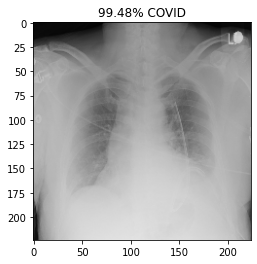

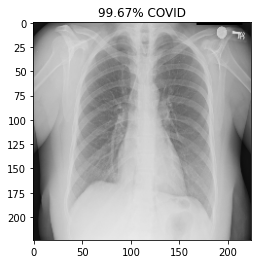

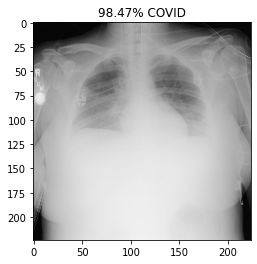

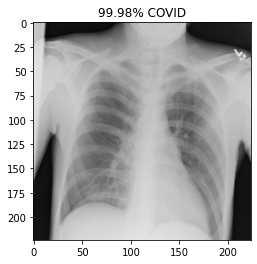

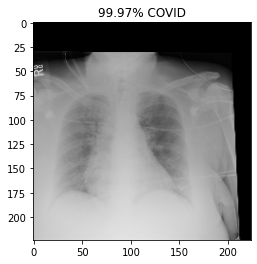

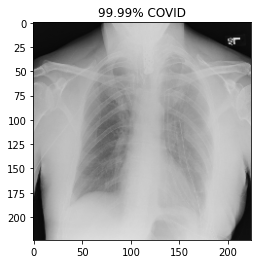

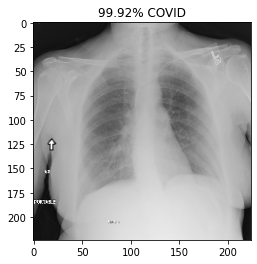

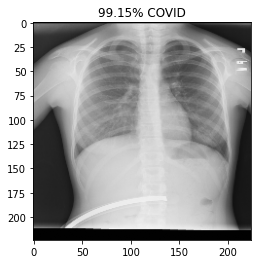

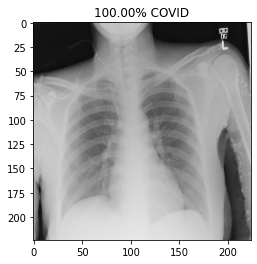

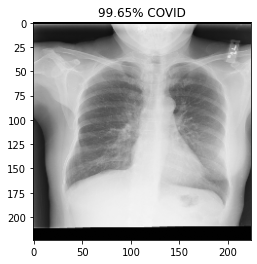

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Confusion Matrix without Normalization


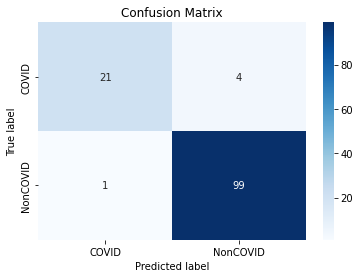

Confusion Matrix with Normalized Values


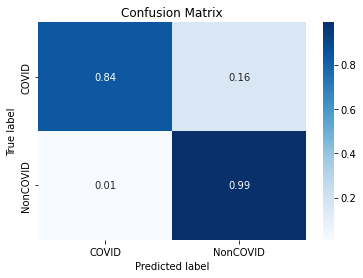

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Making Predicions**